# Landsat NVDI on the fly from Rasdaman

Adam Steer, for NCI. May 2016

Underlying data: AGDC Landsat 1 x 1 degree tiles
Rasdaman version: 9.4
Found at: http://rasdaman.nci.org.au/rasdaman/ows

In [2]:
from io import BytesIO
from PIL import Image
import requests
from osgeo import gdal
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
from lxml import etree

%matplotlib inline

## Compute NVDI for a single tile, single time slice

In [3]:
nvdi_url = 'http://rasdaman.nci.org.au/rasdaman/ows?service=WCS&' \
           'version=2.0.1&request=ProcessCoverages&' \
           'query=for c in (ls8_15_35) return encode((unsigned char) ((((c.nir - c.red) / (c.nir + c.red)) * 200) + 55) [E(1500000:1600000), N(-3500000:-3400000), unix("2013-12-29T00:02:52.000Z")] , "png")'

In [4]:
nvdi_url

'http://rasdaman.nci.org.au/rasdaman/ows?service=WCS&version=2.0.1&request=ProcessCoverages&query=for c in (ls8_15_35) return encode((unsigned char) ((((c.nir - c.red) / (c.nir + c.red)) * 200) + 55) [E(1500000:1600000), N(-3500000:-3400000), unix("2013-12-29T00:02:52.000Z")] , "png")'

In [5]:
%%time
nvdi_response = requests.get(nvdi_url)

CPU times: user 31.1 ms, sys: 16.2 ms, total: 47.3 ms
Wall time: 21.1 s


...need to figure out how to bring that number waaaaaaay down - or maybe it's OK for quite a big region

In [6]:
nvdi_response.status_code

200

In [7]:
if nvdi_response.status_code == 200:
    nvdi_img = Image.open(BytesIO(nvdi_response.content))
    nvdi_array = np.array(nvdi_img)
    

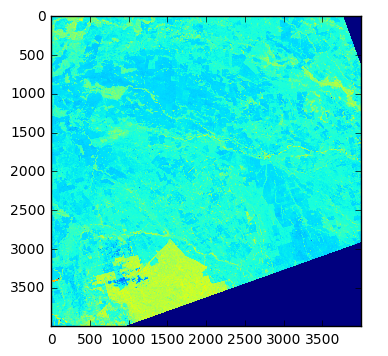

In [8]:
plt.imshow(nvdi_array)

## Paddock scale NVDI
...still only in square boxes for now, say 2km by 2km

In [9]:
nvdi_paddock_url = 'http://rasdaman.nci.org.au/rasdaman/ows?service=WCS&' \
           'version=2.0.1&request=ProcessCoverages&' \
           'query=for c in (ls8_15_35) return encode((unsigned char) ((((c.nir - c.red) / (c.nir + c.red)) * 200) + 55) [E(1500000:1502000), N(-3402000:-3400000), unix("2013-12-29T00:02:52.000Z")] , "png")'

In [10]:
%%time
nvdi_paddock_response = requests.get(nvdi_paddock_url)

CPU times: user 4.05 ms, sys: 1.11 ms, total: 5.16 ms
Wall time: 92.1 ms


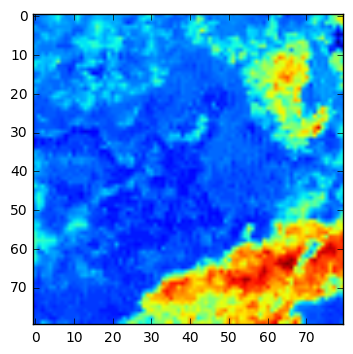

In [11]:
if nvdi_paddock_response.status_code == 200:
    nvdi_paddock_img = Image.open(BytesIO(nvdi_paddock_response.content))
    nvdi_paddock_array = np.array(nvdi_paddock_img)

plt.imshow(nvdi_paddock_array)

## Big paddock scale NVDI
...still only in square boxes for now, say 20km by 20km

In [12]:
nvdi_paddock_url = 'http://rasdaman.nci.org.au/rasdaman/ows?service=WCS&' \
           'version=2.0.1&request=ProcessCoverages&' \
           'query=for c in (ls8_15_35) return encode((unsigned char) ((((c.nir - c.red) / (c.nir + c.red)) * 200) + 55) [E(1500000:1520000), N(-3420000:-3400000), unix("2013-12-29T00:02:52.000Z")] , "png")'

In [13]:
%%time
nvdi_paddock_response = requests.get(nvdi_paddock_url)

CPU times: user 5.51 ms, sys: 1.72 ms, total: 7.23 ms
Wall time: 774 ms


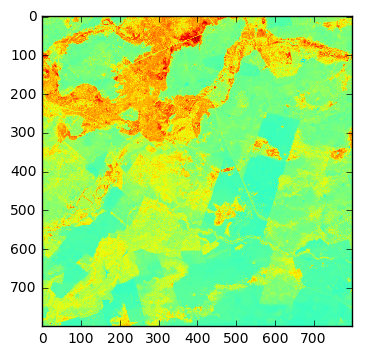

In [14]:
if nvdi_paddock_response.status_code == 200:
    nvdi_paddock_img = Image.open(BytesIO(nvdi_paddock_response.content))
    nvdi_paddock_array = np.array(nvdi_paddock_img)

plt.imshow(nvdi_paddock_array)

These times suggest that there is an optimal strategy for breaking up requests and using more rasservers in the back end. Sending a request for a whole tile doesn't get distributed over multiple rasservers - one process chugs away at it leaving 8 idle. A better strategy for now is to bite off smaller chunks, keep all the rasservers busy. 

## Compute a time series of NVDI for a single point

...or maybe a bunch of points. Let's up the anti. Also it is not a pixel drill - it's a spatially constrained slice through a 4D array on the temporal axis. We use Makitas to drill stuff, not array indexing operations

http://nbviewer.jupyter.org/github/earthserver-eu/geospatial-workflow-with-wcps/blob/master/Time-series-retrieval_climate_sciences.ipynb

Here we show a point picker


### to do:

- CRS transforms, eg from web mercator to Albers equal area.
- automagically choose the correct tile based on input coords (pretty simple)
- automagically limit times (not simple, need to parse WCS XML... uugh)


In [50]:
def plot_timeseries(params):
    # WCPS query format for NVDI
    nvdi_url_tmpl = 'http://rasdaman.nci.org.au/rasdaman/ows?service=WCS&' \
           'version=2.0.1&request=ProcessCoverages&' \
           'query=for c in (%s) return encode((unsigned char) ((((c.nir - c.red) / (c.nir + c.red)) * 200) + 55) [E(%d), N(%d), unix("%s":"%s")] , "csv")'
    query = nvdi_url_tmpl % (params["coverage"],params["point_x"],params["point_y"],params["start_time"],params["stop_time"])
    ts = requests.get(query)
    timeseries = np.fromstring(ts.content, dtype=np.uint8)
    
    x_ = np.arange(len(timeseries))


    from ipywidgets import interact
 
    from bokeh.io import push_notebook, show, output_notebook
    from bokeh.plotting import figure, show
    output_notebook()

    p = figure(title="NVDI plot", x_axis_label='time', y_axis_label='NVDI', tools="tap,pan,wheel_zoom,crosshair,hover",)
    p.line(x_,timeseries, line_width=3.0)

    show(p, notebook_handle=True)
    
    return timeseries

In [16]:
# WCPS query format for NVDI
nvdi_url_tmpl = 'http://rasdaman.nci.org.au/rasdaman/ows?service=WCS&' \
           'version=2.0.1&request=ProcessCoverages&' \
           'query=for c in (%s) return encode((unsigned char) ((((c.nir - c.red) / (c.nir + c.red)) * 200) + 55) [E(%d), N(%d), unix("%s":"%s")] , "csv")'

In [17]:
params = {"coverage" : "ls8_15_35",
          "start_time":"2014-12-29T00:02:52.000Z",
          "stop_time": "2015-10-01T00:00:00.000Z",
          "point_x" : 1550001,
          "point_y" : -3450001}


In [18]:
query = nvdi_url_tmpl % (params["coverage"],params["point_x"],params["point_y"],params["start_time"],params["stop_time"])



In [19]:
query

'http://rasdaman.nci.org.au/rasdaman/ows?service=WCS&version=2.0.1&request=ProcessCoverages&query=for c in (ls8_15_35) return encode((unsigned char) ((((c.nir - c.red) / (c.nir + c.red)) * 200) + 55) [E(1550001), N(-3450001), unix("2014-12-29T00:02:52.000Z":"2015-10-01T00:00:00.000Z")] , "csv")'

In [20]:
%%time
ts = requests.get(query)

CPU times: user 4.47 ms, sys: 1.28 ms, total: 5.76 ms
Wall time: 1.81 s


In [21]:
ts.content

b'{128,0,60,62,98,0,95,96,94,0,94,93,93,0,97,98,95,0,94,94,93,0,79,81,78,0,98,98,107,0,95,97,109,0,95,96,98,0,76,77,98,0,87,86,111,0,105,107,65,0,71,71,162,0,183,184,145,0,178,178,212,0,206,206,177,177,159,0}'

In [48]:
timeseries = np.fromstring(ts.content, dtype=np.uint8)

In [53]:
ts = plot_timeseries(params)

Loading BokehJS ...

### An ordinary MPL plot because bokeh won't work on github

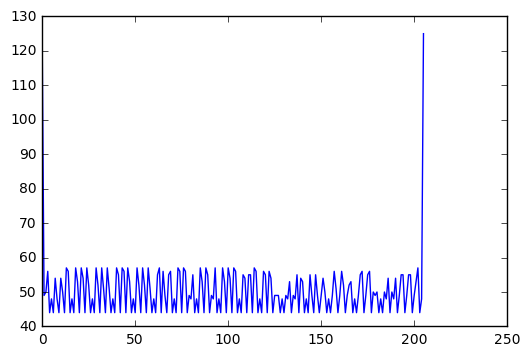

In [54]:
plt.plot(ts)